In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings

warnings.filterwarnings('ignore')


def lstm_sliding_window_prediction(area: str):
    # 1. 創建模擬時間序列數據
    data = pd.read_csv(r"data\owid-covid-data.csv")

    # 選擇某一地區的數據進行分析，例如 "World"
    region_data = data[data['iso_code'] == area]
    region_data['new_cases'] = region_data['new_cases'].fillna(0)  # 填充缺失值

    # 2. 數據標準化 (z-score)
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(region_data['new_cases'].values.reshape(-1, 1))

    # 使用移動窗格創建時間序列數據集
    def create_sliding_window_dataset(data, window_size=10):
        X, y = [], []
        for i in range(len(data) - window_size):
            X.append(data[i:i + window_size, 0])
            y.append(data[i + window_size, 0])
        return np.array(X), np.array(y)

    # 定義窗口大小
    window_size = 28

    # 創建滑動窗口數據集
    X, y = create_sliding_window_dataset(standardized_data, window_size)

    # 重塑 X 為 LSTM 的輸入格式 (樣本數, 時間步長, 特徵數)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    # 分割為訓練集和測試集
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # 3. 構建 LSTM 模型
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(window_size, 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)  # 單一輸出值
    ])

    # 編譯模型
    model.compile(optimizer='adam', loss='mean_absolute_error')

    # 4. 訓練模型
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    # 5. 預測並還原預測結果
    predicted_cases = model.predict(X_test)
    predicted_cases = scaler.inverse_transform(predicted_cases)  # 還原標準化

    # 還原測試集實際值
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # 6. 視覺化結果
    plt.figure(figsize=(20, 6))
    plt.plot(region_data['date'][-len(y_test_actual):], y_test_actual, color='blue', label='Actual Cases')
    plt.plot(region_data['date'][-len(predicted_cases):], predicted_cases, color='red', label='Predicted Cases')
    plt.title('Sliding Window Prediction (New COVID Cases)')
    plt.xlabel('Date')
    plt.ylabel('New Cases')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # 7. 評估模型
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    def calculate_mape(true_values, predictions):
        """
        計算 Mean Absolute Percentage Error (MAPE)
        """
        true_values = np.array(true_values)
        predictions = np.array(predictions)
        return np.mean(np.abs((true_values - predictions) / true_values)) * 100

    def calculate_ppe(true_values, predictions):
        """
        計算 Peak Prediction Error (PPE)
        """
        peak_true_value = np.max(true_values)
        peak_true_time = np.argmax(true_values)

        peak_pred_value = np.max(predictions)
        peak_pred_time = np.argmax(predictions)

        value_error = np.abs(peak_true_value - peak_pred_value)
        time_error = np.abs(peak_true_time - peak_pred_time)

        return value_error, time_error

    mae = mean_absolute_error(y_test_actual, predicted_cases)
    rmse = np.sqrt(mean_squared_error(y_test_actual, predicted_cases))
    mape = calculate_mape(y_test_actual, predicted_cases)
    ppe_value_error, ppe_time_error = calculate_ppe(y_test_actual, predicted_cases)

    print(f'MAE: {mae}')
    print(f'MAE / Mean: {mae / np.mean(y_test_actual)}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape:.2f}%')
    print(f'Peak Prediction Error (Value): {ppe_value_error}')
    print(f'Peak Prediction Error (Time): {ppe_time_error} days')


In [8]:
regions=["MYS", "ARG", "MEX", "JPN", "CAN", "THA", "VNM", "TWN", "CHN", "SGP"]

Region: MYS
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


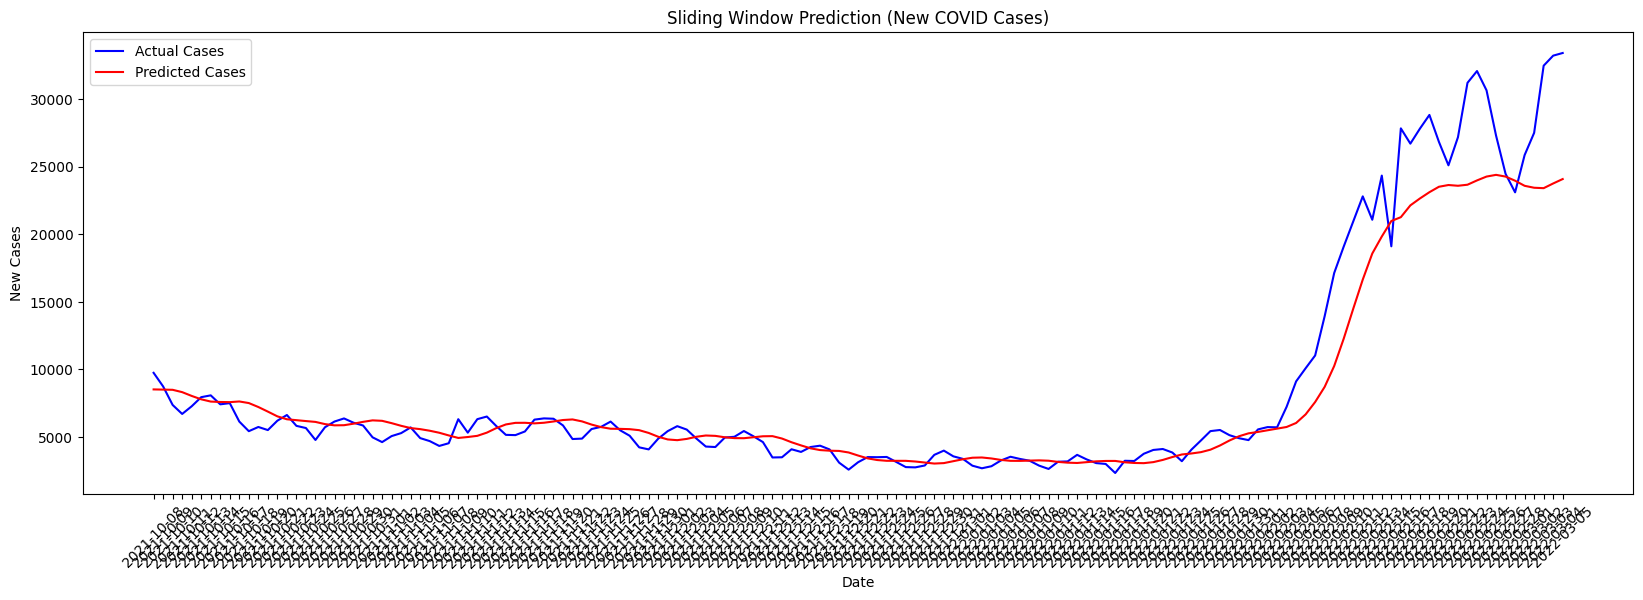

MAE: 1417.704422713926
MAE / Mean: 0.16484356252853222
RMSE: 2502.1016763390276
MAPE: 14.44%
Peak Prediction Error (Value): 9013.59375
Peak Prediction Error (Time): 7 days
Region: ARG
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


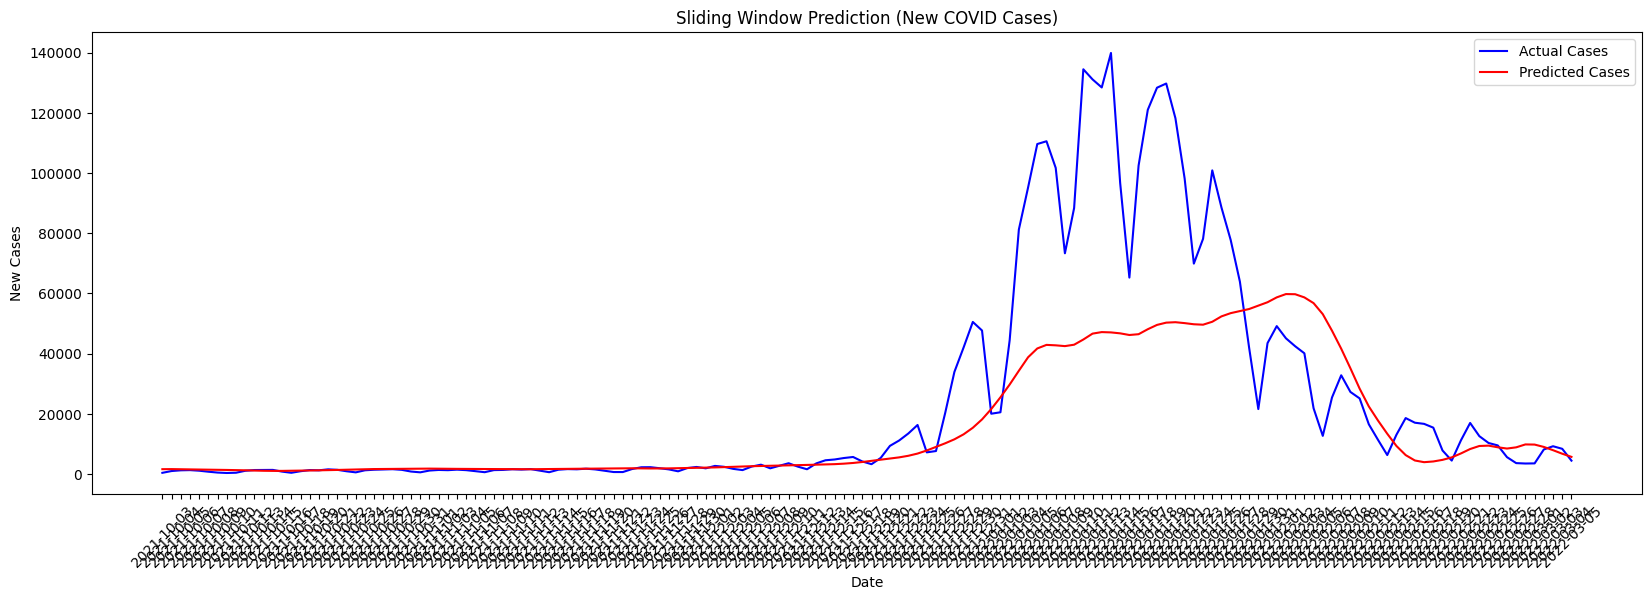

MAE: 12598.884965376421
MAE / Mean: 0.5279567226202209
RMSE: 25342.76122935708
MAPE: 55.11%
Peak Prediction Error (Value): 80086.609375
Peak Prediction Error (Time): 19 days
Region: MEX
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


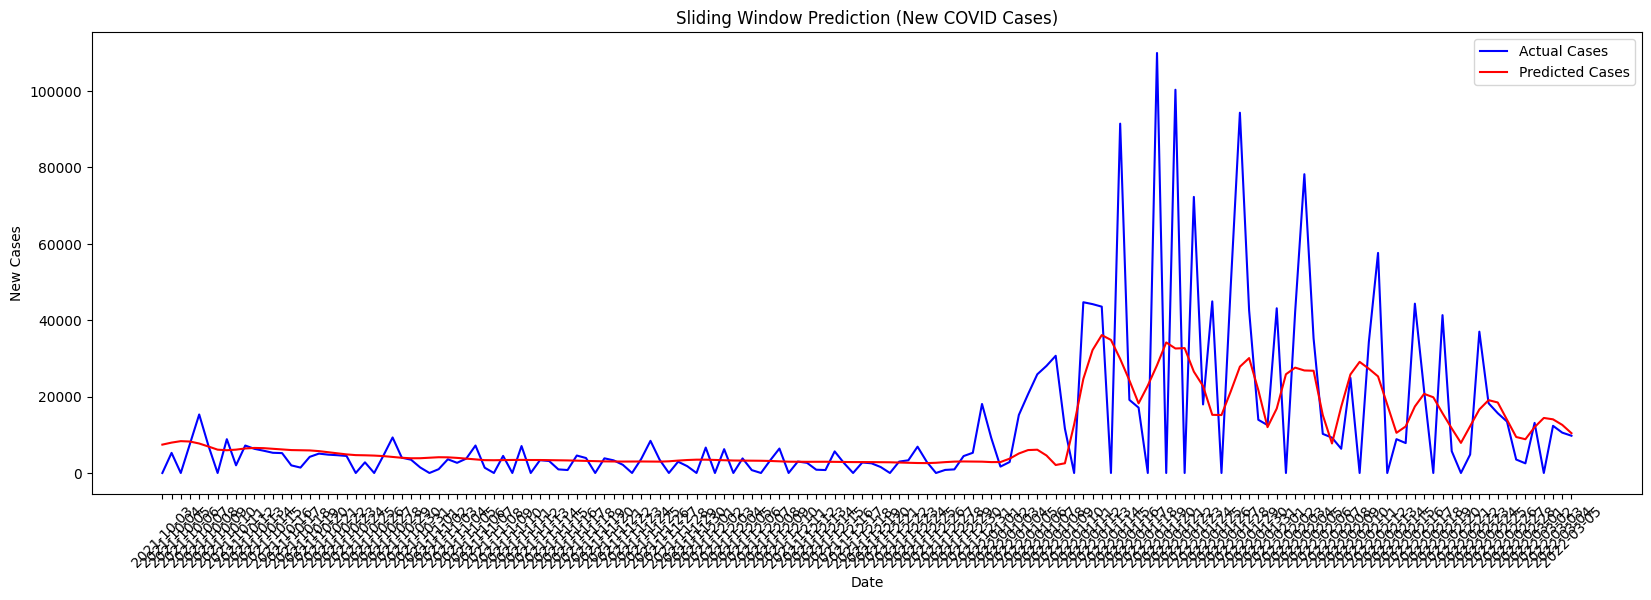

MAE: 8520.217787705458
MAE / Mean: 0.6996401533671751
RMSE: 16295.432981105501
MAPE: inf%
Peak Prediction Error (Value): 73814.24609375
Peak Prediction Error (Time): 6 days
Region: JPN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


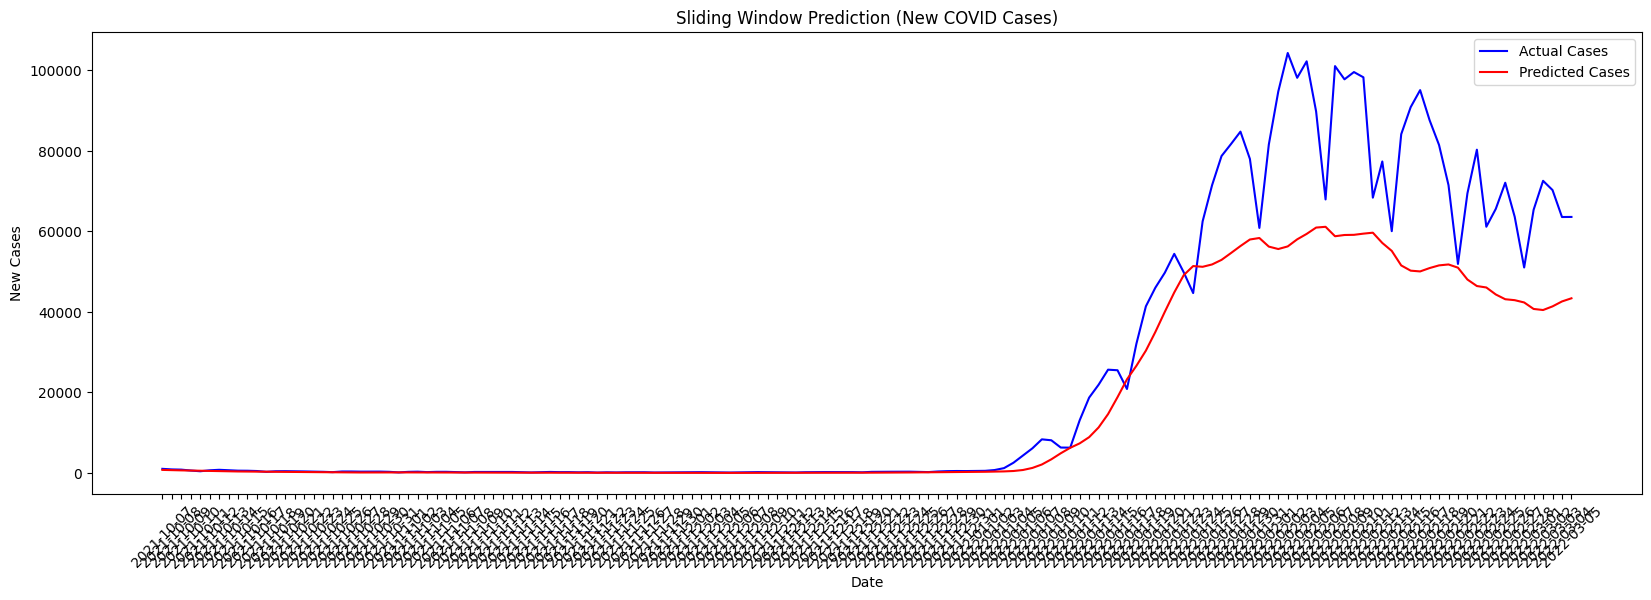

MAE: 7877.275738620224
MAE / Mean: 0.32552367262400106
RMSE: 15114.54043900737
MAPE: 62.90%
Peak Prediction Error (Value): 43207.26171875
Peak Prediction Error (Time): 4 days
Region: CAN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


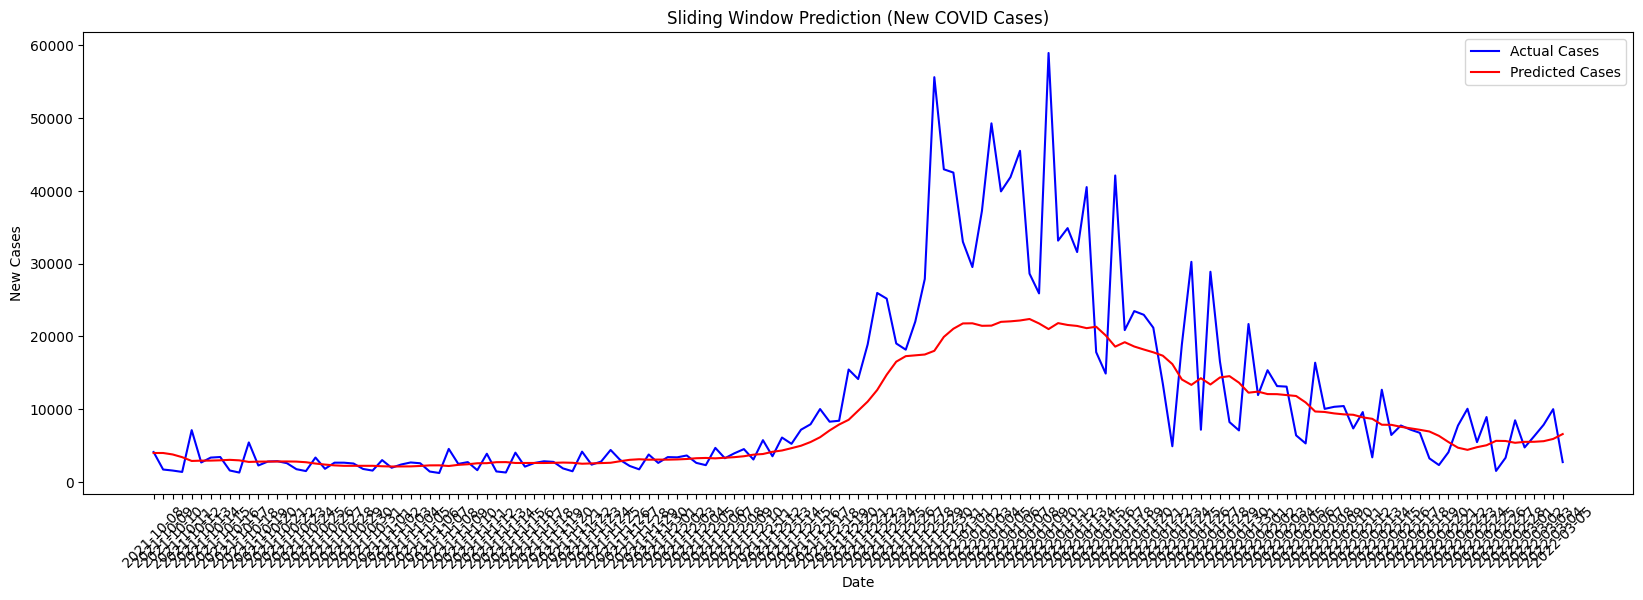

MAE: 4392.200690147861
MAE / Mean: 0.3901083124691706
RMSE: 8078.726222434915
MAPE: 41.10%
Peak Prediction Error (Value): 36545.74609375
Peak Prediction Error (Time): 2 days
Region: THA
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


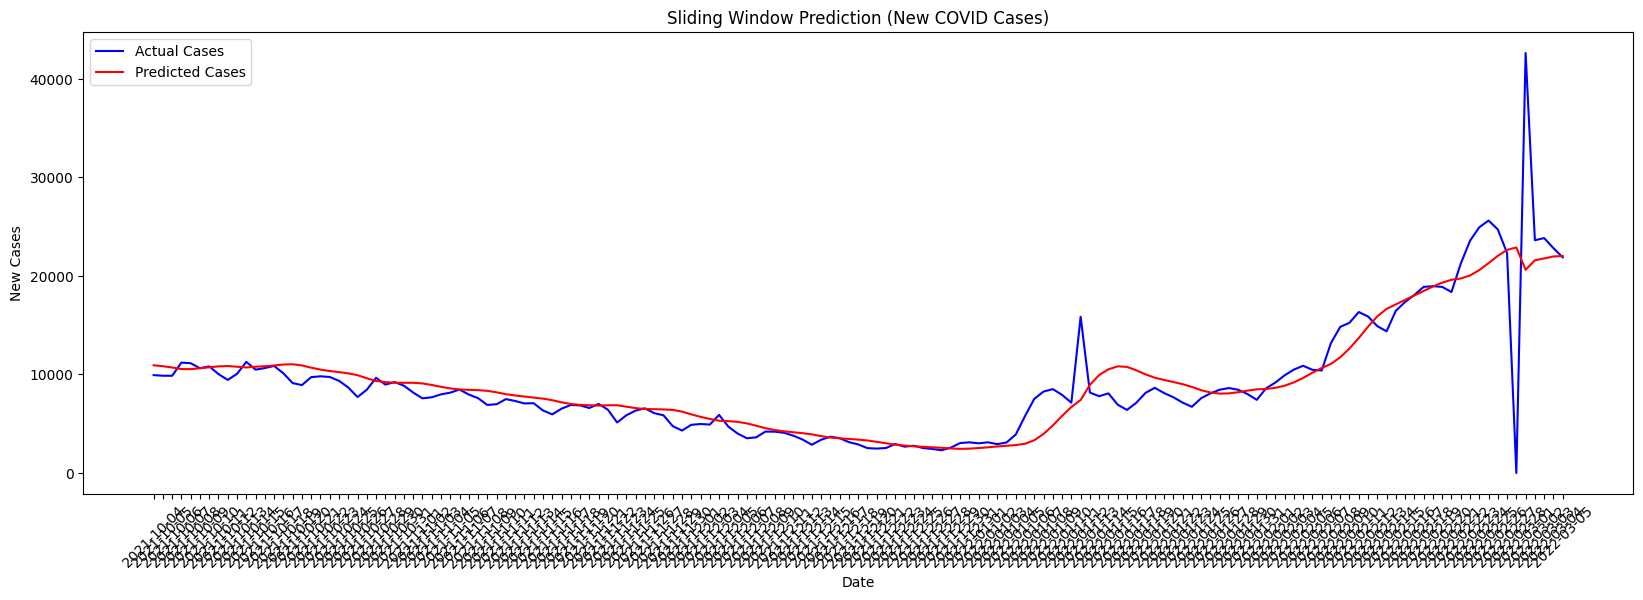

MAE: 1361.1014811197917
MAE / Mean: 0.14989856248336575
RMSE: 3018.5041093261902
MAPE: 32891398529056136.00%
Peak Prediction Error (Value): 19732.3671875
Peak Prediction Error (Time): 1 days
Region: VNM
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


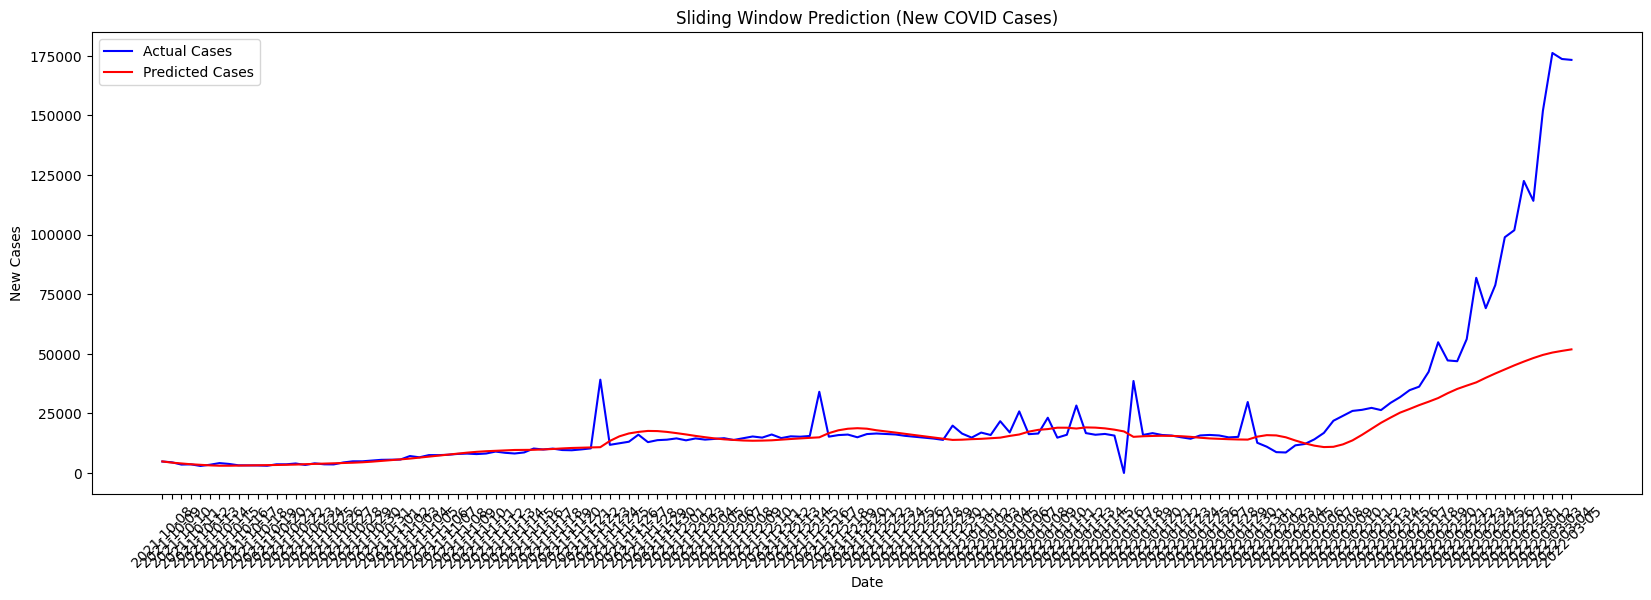

MAE: 8671.612730704697
MAE / Mean: 0.37938654210477013
RMSE: 23418.88961353379
MAPE: inf%
Peak Prediction Error (Value): 124308.38671875
Peak Prediction Error (Time): 2 days
Region: TWN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


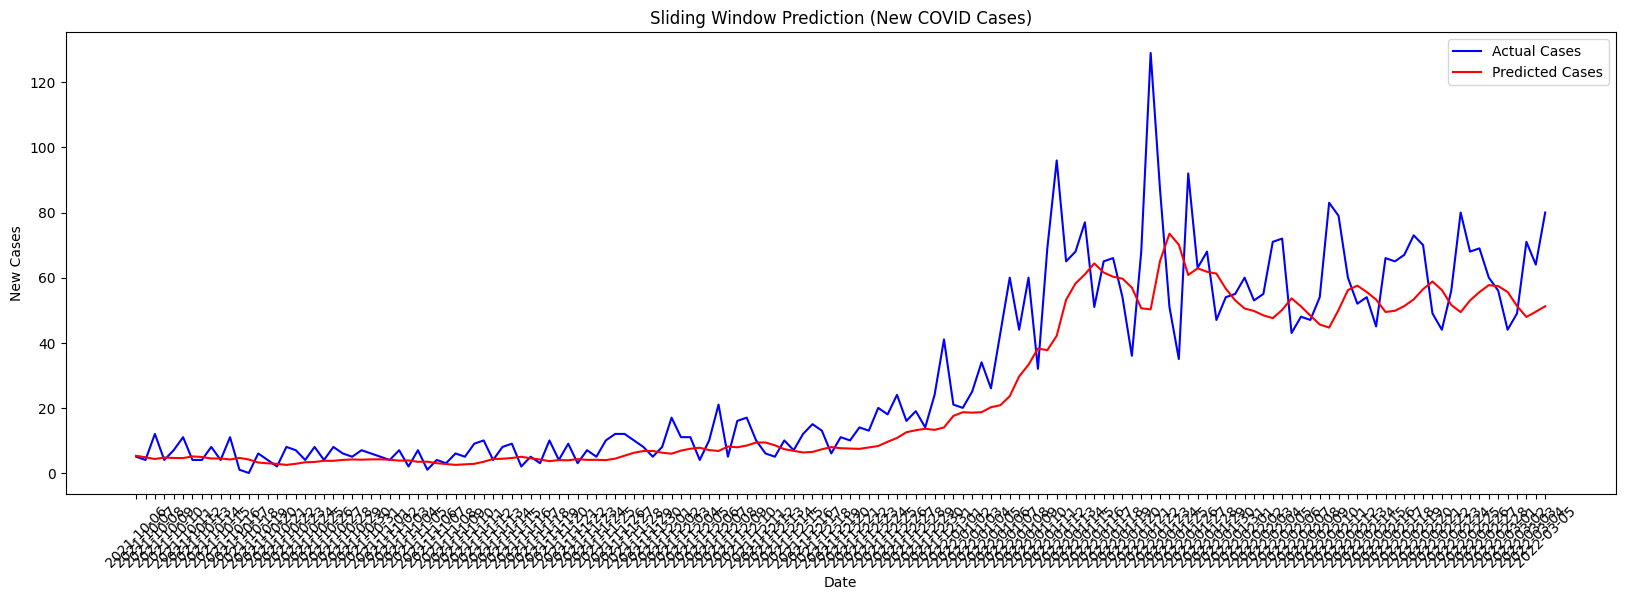

MAE: 8.730666124268083
MAE / Mean: 0.29070134173417433
RMSE: 13.940232560007885
MAPE: inf%
Peak Prediction Error (Value): 55.498146057128906
Peak Prediction Error (Time): 2 days
Region: CHN
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


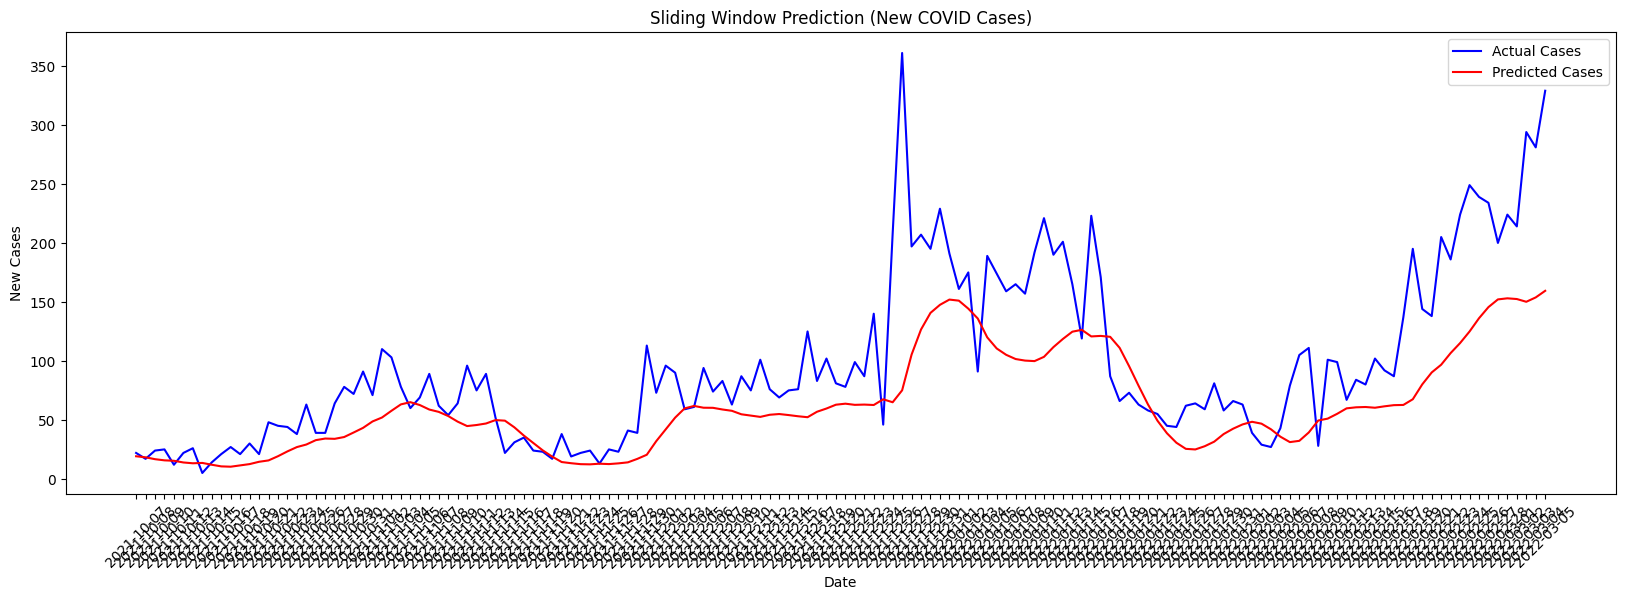

MAE: 39.165792032877604
MAE / Mean: 0.40424336371923486
RMSE: 55.86323915660773
MAPE: 38.68%
Peak Prediction Error (Value): 201.57958984375
Peak Prediction Error (Time): 68 days
Region: SGP
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


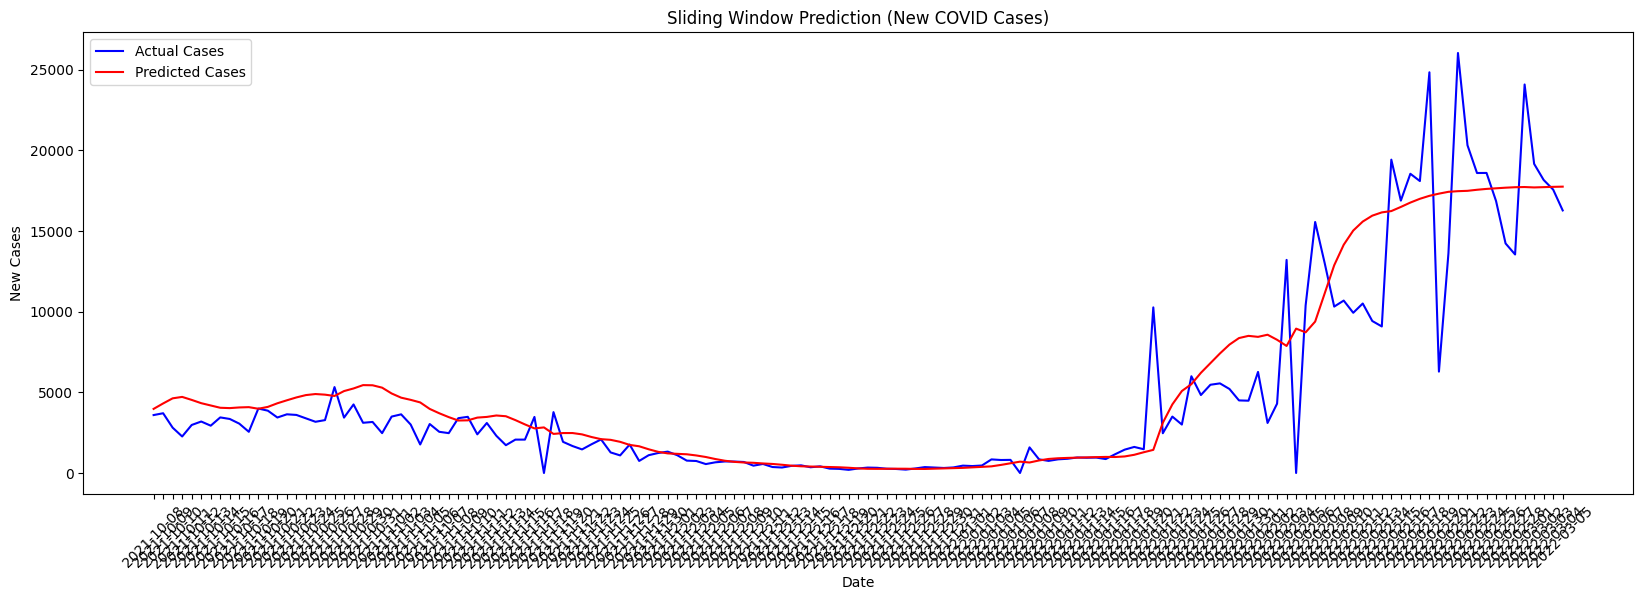

MAE: 1481.3418306696335
MAE / Mean: 0.314058404707143
RMSE: 2534.113976123581
MAPE: inf%
Peak Prediction Error (Value): 8283.908203125
Peak Prediction Error (Time): 11 days


In [11]:
for region in regions:
    print("=" * 50)
    print(f"Region: {region}")
    
    lstm_sliding_window_prediction(region)

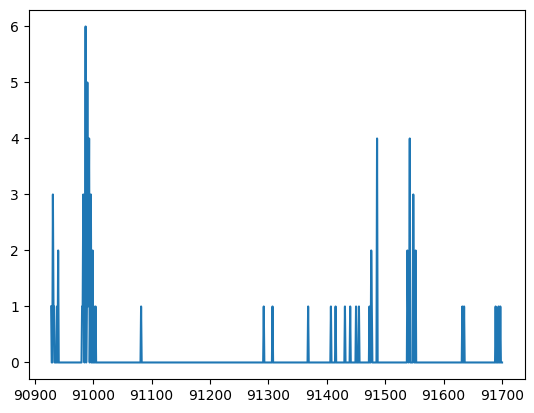

In [49]:
data = pd.read_csv(r"data\owid-covid-data.csv")
region_data = data[data['iso_code'] == "MAC"]
from matplotlib.pyplot import plot
plot(region_data["new_cases"])

In [51]:
region_data["new_cases"].describe()

count    773.000000
mean       0.104787
std        0.504529
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: new_cases, dtype: float64